<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>


Optoélectronique GEL-4203, GEL-7041

Département de Génie Électrique et de Génie Informatique

Automne 2025

Université Laval

# Éloi Blouin

# Travail 1

##### Remise
- Votre notebook (.ipynb) ou un document au format PDF contenant vos démarches, réponses clairement identifiées et vos scripts (Python, Matlab ou autre).
- Sur la boîte de dépôt dans MonPortail
- Au plus tard le mercredi 17 septembre 2025 à 12h30

##### Équipe
- Ce travail est *individuel*

##### Pondération :
- GEL-4203 : Ce travail vaut pour *5%* de la note finale
- GEL-7041 : Ce travail vaut pour *5%* de la note finale

## Consignes pour répondre aux questions

- Utilisez des cellules de Markdown pour fournir des explications écrites et des équations mathématiques.
    - Vous pouvez faire une équation $\LaTeX$ sur une ligne: $\sum_{n = 0}^\infty x^n$.
    - Vous pouvez faire une équation $\LaTeX$ centrée: $$\sum_{n = 0}^\infty x^n.$$
    - Vous pouvez imbriquer des listes:
        - Niveau 2
            - Niveau 3



- Utilisez des cellules de code pour effectuer vos calculs numériques. Prenez soin de bien commenter votre code, de choisir des noms de variables explicites et de "print()" vos réponses.

- N'hésitez-pas à encapsuler vos calculs répétés dans des fonctions. À plusieurs endroits, il vous sera suggéré de créer des fonctions spécifiques. Ce n'est pas obligatoire mais fortement conseillé.

- Seules les librairies suivantes sont permises. Parmi celles-ci figure les fonctions de résolution de guide d'onde 1D.

- **Indiquez les unités des réponses.**

- **Identifiez correctement vos figures (axes, titre, etc.)**

- **Donnez les démarches complètes aux solutions.**

In [65]:
# @title
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

""" Créé par Jonathan Cauchon pour le cours GEL-4203

Historique des modifs:

    - 20 sept 2020: guide_1d_analytique
        dans l'utilisation de la fonction estimate_beta, si aucune solution n'est trouvée,
        guide_id_analytique augmente la resolution sur beta jusqu'à ce qu'une solution
        soit trouvée.



"""


def estimate_beta(wvl, t, n1, n2, n3, beta_res):
    """
        Function qui estime les solutions du guide d'onde plan
    """

    wvl = np.asarray(wvl)
    k = 2*np.pi/wvl
    beta = np.linspace(np.max([n1,n3])*k, n2*k, beta_res)[:-1]
    beta = beta if beta.ndim == 2 else np.expand_dims(beta, -1)
    wvl = wvl if wvl.ndim == 1 else np.expand_dims(wvl, 0)

    # TE
    h = np.sqrt((k*n2)**2 - beta**2)

    p = np.sqrt(beta**2 - (k*n3)**2)
    q = np.sqrt(beta**2 - (k*n1)**2)
    zero_TE = np.tan(h*t) - (p + q)/h/(1 - p*q/h**2)

    # TM
    p_ = p*(n2/n3)**2
    q_ = q*(n2/n1)**2
    zero_TM = np.tan(h*t) - (p_ + q_)/h/(1 - p_*q_/h**2)

    beta_TE = []
    beta_TM = []

    for i in range(beta.shape[-1]):
        # solution esitmée: croisement du zéro en direction négative (+ -> -)
        solutions_TE = np.where(np.sign(zero_TE[:-1,i]) - np.sign(zero_TE[1:,i]) == 2)[0]
        solutions_TM = np.where(np.sign(zero_TM[:-1,i]) - np.sign(zero_TM[1:,i]) == 2)[0]
        # print(solutions_TE, solutions_TM)
        # plt.plot(zero_TE)
        # plt.plot([0,beta.shape[0]], [0,0])
        # plt.ylim((-1,1))
        # plt.show()

        beta_sol_TE = beta[solutions_TE,i]
        beta_sol_TM = beta[solutions_TM,i]
        beta_TE.append(beta_sol_TE)
        beta_TM.append(beta_sol_TM)

    return beta_TE, beta_TM


def guide_1d_analytique(wvl, t, n1, n2, n3):
    """ Solution analytique du guide d'onde plan

    Paramètres:
        wvl: longueur d'onde [m] (float, liste ou numpy array)
        t  : épaisseur du coeur [m] (float)
        n1, n2, n3: indices des trois régions (floats)

    retourne:
        neff_TE, neff_TM: les indices effectifs des modes TE et TM (les solutions).
                        Ce sont des listes de listes. Chaque sous-liste de la liste est pour
                        une longueur d'onde de 'wvl' et chaque item de la sous-liste contient
                        tous les indices supportés par le guide, en ordre croissant.

    exemple d'usage:

        wvl = np.linspace(1530e-9,1560e-9,1000) # longueurs d'onde considérées
        neff_TE, neff_TM = guide_1d_analytique(wvl, 220e-9, 1.44, 3.45, 1.44)

        print(neff_TM[0][0]) # le mode TM fondamental (TM_0) à 1530 nm
    """

    wvl = np.asarray(wvl)
    wvl = wvl if wvl.ndim == 1 else np.expand_dims(wvl, 0)

    def equation_TE(beta):
        k = 2*np.pi/wvl
        h = np.sqrt((k*n2)**2 - beta**2)
        p = np.sqrt(beta**2 - (k*n3)**2)
        q = np.sqrt(beta**2 - (k*n1)**2)

        return np.tan(h*t) - (p + q)/h/(1 - p*q/h**2)

    def equation_TM(beta):
        k = 2*np.pi/wvl
        h = np.sqrt((k*n2)**2 - beta**2)
        p = np.sqrt(beta**2 - (k*n3)**2)
        q = np.sqrt(beta**2 - (k*n1)**2)
        p_ = p*(n2/n3)**2
        q_ = q*(n2/n1)**2

        return np.tan(h*t) - (p_ + q_)/h/(1 - p_*q_/h**2)

    beta_res = 1000
    beta_TE_estimate, beta_TM_estimate = estimate_beta(wvl, t, n1, n2, n3, beta_res)
    #print(beta_TE_estimate, beta_TM_estimate)

    # si la solution est trop tight faut augmenter la résolution
    while (len(beta_TE_estimate[0]) < 1) or (len(beta_TM_estimate[0]) < 1):
        beta_res *= 10
        beta_TE_estimate, beta_TM_estimate = estimate_beta(wvl, t, n1, n2, n3, beta_res)

    neff_TE, neff_TM = [], []

    for i in range(wvl.shape[0]):
        for j in range(len(beta_TE_estimate[i])):
            beta_TE_estimate[i][j] = scipy.optimize.fsolve(equation_TE, beta_TE_estimate[i][j]).squeeze()
        for j in range(len(beta_TM_estimate[i])):
            beta_TM_estimate[i][j] = scipy.optimize.fsolve(equation_TM, beta_TM_estimate[i][j]).squeeze()

        neff_TE.append(np.flip(beta_TE_estimate[i]*wvl[i]/2/np.pi).tolist())
        neff_TM.append(np.flip(beta_TM_estimate[i]*wvl[i]/2/np.pi).tolist())


    return neff_TE, neff_TM



def tracer_modes(wvl, t, n1, n2, n3, plot_TE=True, plot_TM=True,
                 num_mode = [0]):
    # num_mode : ordre du mode à tracer - 1= mode fondamental
    mu0 = 4*np.pi*1e-7
    epsilon0 = 8.85e-12
    eta = np.sqrt(mu0/epsilon0)
    c = 3e8

    assert type(wvl) == float, "Utiliser une seule longueur d'onde"
    neff_TE, neff_TM = guide_1d_analytique(wvl, t, n1, n2, n3)

    numPoints = 1000
    x1 = np.linspace(-3*t, -t/2, numPoints)
    x2 = np.linspace(-t/2, t/2, numPoints)
    x3 = np.linspace( t/2, 3*t, numPoints)
    x = np.hstack((x1,x2, x3))
    nx = np.hstack((n1*np.ones(numPoints), n2*np.ones(numPoints), n3*np.ones(numPoints)))

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot([-t/2*1e6,-t/2*1e6,t/2*1e6,t/2*1e6],[-2,2,2,-2], "k--")
    ax[1].plot([-t/2*1e6,-t/2*1e6,t/2*1e6,t/2*1e6],[-2,2,2,-2], "k--")


    if plot_TE:
        # for i, n in enumerate(neff_TE[0]):
        for ii in range(0,len(num_mode)): # pour pouvoir tracer seulement un mode voulu
            n = neff_TE[0][num_mode[ii]]
            beta = 2*np.pi*n/wvl
            k = 2*np.pi/wvl
            h = np.sqrt((k*n2)**2 - beta**2)
            p = np.sqrt(beta**2 - (k*n3)**2)
            q = np.sqrt(beta**2 - (k*n1)**2)
            E_field = np.hstack(( np.exp(q*(x1 + t/2)),
                                (np.cos(h*(x2+t/2))+q/h*np.sin(h*(x2+t/2))),
                                (np.cos(h*t) + q/h*np.sin(h*t))*np.exp(-p*(x3 - t/2)) ))
            H_field = E_field*nx/eta
            ax[0].plot(x*1e6, E_field/np.max(np.abs(E_field)), label="TE"+str(num_mode[ii]))
            ax[1].plot(x*1e6, H_field/np.max(np.abs(H_field)), label="TE"+str(num_mode[ii]))

    if plot_TM:
        # for i, n in enumerate(neff_TM[0]):
        for ii in range(0,len(num_mode)): # pour pouvoir tracer seulement un mode voulu
            n = neff_TM[0][num_mode[ii]]
            beta = 2*np.pi*n/wvl
            k = 2*np.pi/wvl
            h = np.sqrt((k*n2)**2 - beta**2)
            p = np.sqrt(beta**2 - (k*n3)**2)
            q = np.sqrt(beta**2 - (k*n1)**2)
            p_ = p*(n2/n3)**2
            q_ = q*(n2/n1)**2
            H_field = np.hstack(( h/q_*np.exp(q*(x1 + t/2)),
                                (h/q_*np.cos(h*(x2+t/2))+np.sin(h*(x2+t/2))),
                                (h/q_*np.cos(h*t) + np.sin(h*t))*np.exp(-p*(x3 - t/2)) ))
            H_field = np.hstack(( h/q_*np.exp(q*(x1+t/2)),
                (h/q_*np.cos(h*(x2+t/2))+np.sin(h*(x2+t/2))),
                (h/q_*np.cos(h*t)+np.sin(h*t))*np.exp(-p*(x3-t/2)) ))

            ax[1].plot(x*1e6, H_field/np.max(np.abs(H_field)), label="TM"+str(num_mode[ii]))
            E_field = H_field*eta/nx
            ax[0].plot(x*1e6, E_field/np.max(np.abs(E_field)), label="TM"+str(num_mode[ii]))


    ax[0].set_ylim((-1.1,1.1))
    ax[0].set_ylabel("E")
    ax[0].set_xlabel(r"y ($\mu$m)")
    ax[0].legend()


    ax[1].set_ylim((-1.1,1.1))
    ax[1].set_ylabel("H")
    ax[1].set_xlabel(r"y ($\mu$m)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [66]:
"""
Librairies permises
N'utilisez que les librairies Python suivantes
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
#from GEL4203_utils import guide_1d_analytique

# Question 1 - Ondes planes (35%)

#### (A) (5 points) Quelle est la largeur de la bande O (1260 nm à 1360 nm) en fréquence?

Pour passer de longueur d'onde à fréquence, on utilise la relation suivante.
$$ν = \frac{c}{λ} $$

In [67]:
λ_1 = 1260*10**(-9)
λ_2 = 1360E-9
print(cte.c)
ν_1 = cte.c/λ_1
ν_2 = cte.c/λ_2

Δν = ν_1 - ν_2

print(f"$ν_1$= {ν_1:.0f} Hz = {ν_1/cte.tera:.2f} THz")
print(f"ν_2 = {ν_2:.0f} Hz = {ν_2/cte.tera:.2f} THz")
print(f"Δν = {Δν:.0f} Hz  = {Δν/cte.tera:.2f} THz")

299792458.0
$ν_1$= 237930522222222 Hz = 237.93 THz
ν_2 = 220435630882353 Hz = 220.44 THz
Δν = 17494891339869 Hz  = 17.49 THz


#### (B) (5 points) Soit le champ électrique complexe d'une onde plane $\tilde{E} = \tilde{E}_0 \exp(j (\omega t - k z+\phi_0))$. À partir de l'équation d'onde de Maxwell, démontrez que la vitesse de phase est donnée par : $$v_p = \frac{1}{\sqrt{\mu_0\epsilon_0\epsilon_r}}.$$

Les 4 équations de Maxwell sont
$$
∇⋅\vec{E} = \frac{ρ}{ϵ_0}\\
∇×\vec{E} = - \frac{∂\vec{B}}{∂t}\\
∇⋅\vec{B} = 0\\
∇×\vec{B} = μ\vec{J}+ μϵ\frac{∂\vec{E}}{∂t}
$$

Ici, le courant est la densité de charge est nulle alors $\vec{J}=0$ et $ρ=0$.

Commençons en prenant la deuxième équation et en appliquant un rotationnel supplémentaire.
$$
∇×\vec{E} = - \frac{∂\vec{B}}{∂t}\\
∇×( ∇×\vec{E}) = - \frac{∂}{∂t} (∇×\vec{B})\\
∇×( ∇×\vec{E}) = - \frac{∂}{∂t}(0 + μϵ\frac{∂\vec{E}}{∂t})\\
∇×( ∇×\vec{E}) = - μϵ\frac{∂^2\vec{E}}{∂t^2}\\
$$
Avec les propriétés vectorielles de la divergence et du rotationnel, on simplifie

$$
∇×( ∇×\vec{E}) = ∇( ∇⋅\vec{E})-∇^2\vec{E} = 0-∇^2\vec{E}
$$
ce qui donne
$$
-∇^2\vec{E} = - μϵ\frac{∂^2\vec{E}}{∂t^2}\\
∇^2\vec{E} = μϵ\frac{∂^2\vec{E}}{∂t^2}\\
$$
Maintenant, revenons à l'équation pour la vitesse de phase qui est définie comme :

$$
v_p = \frac{ω}{k}
$$



Ce qui provient de l'équation d'onde générale suivante :
$$\frac{∂^2\tilde{E}}{∂z^2} = \frac{1}{v_p^2}\frac{∂^2\tilde{E}}{∂t^2}$$
$$
-k^2 \tilde{E}_0 e^{j (\omega t - k z+\phi_0)} = \frac{-ω^2}{v_p^2} \tilde{E}_0e^{j (\omega t - k z+\phi_0)}\\
k^2 = \frac{1}{v^2} ω^2\\
v_p^2 = \frac{ω^2}{k^2}\\
v_p = \frac{ω}{k}
$$

En correspondant les deux équations, on réalise que la vitesse de l'onde est relié à la permittivité électrique $ϵ = ϵ_0ϵ_r$ et à la perméabilité magnétique $μ = μ_0μ$


$$
∇^2\vec{E} = μϵ\frac{∂^2\vec{E}}{∂t^2}\\
\frac{∂^2\vec{E}}{∂z^2} = μϵ\frac{∂^2\vec{E}}{∂t^2}\\
\frac{∂^2\tilde{E}}{∂z^2} = \frac{1}{v_p^2}\frac{∂^2\tilde{E}}{∂t^2}\\
⇓\\
\frac{1}{v_p^2} = μϵ = μ_0μ_rϵ_0ϵ_r = \frac{ω}{k}
$$
Avec la perméabilité magnétique $ϵ_r=1$ car le milieu est non magnétique.
$$v_p = \frac{1}{\sqrt{μ_0ϵ_0ϵ_r}}$$






#### (C) (5 points) Quelle est la vitesse de phase d'une onde ($\lambda $ =  1310 nm) si elle se propage dans l'air?  Quelle est sa vitesse de phase si elle se propage dans une fibre optique (n = 1.44)?

La vitesse de phase s'écrit aussi en fonction de la vitesse de la lumière et de l'indice de réfraction $n$ du milieu.
$$v_p = \frac{c}{n}$$


In [68]:
λ = 1310E-9
print(cte.c)

print("v_p_air =", cte.c/1, "[m/s]")
print("v_p_n=144 =", cte.c/1.44, "[m/s]")

299792458.0
v_p_air = 299792458.0 [m/s]
v_p_n=144 = 208189206.94444445 [m/s]


#### (E) (5 points) Démontrez que:
$$ \alpha [dB/m] = 4.34 \alpha [1/m]. $$

#### où $\alpha$ correspond au coefficient d'absorption.

Le coefficient d'absorption est un taux de décroissant de l'amplitude selon une exponentielle décroissante après un mètre de distance parcourue.
Le taux de décroissance linéaire serait $α_{lin}$ dans la formule
$$P(L) = P_0 e^{-α_{lin}L}$$
Ensuite, on peut passer de linéaire à logarithmique à base 10 avec la formule du coefficient de perte en $dB$ qui est :
$$
α_{log_{10}} = -\frac{1}{L}10log_{10} \left(\frac{P(L)}{P_0}\right) = -10log_{10} \left(\frac{P_0e^{-α_{lin}⋅L}}{P_0}\right) = -10\frac{1}{ln(10)} ln(e^{-α_{lin}⋅L})= \frac{-10}{L}⋅-α_{lin}L⋅\frac{1}{ln(10)}⋅\ln\left( e^1\right) = α_{lin}10⋅0.43429 = 4.3429 α_{lin}
$$
ce qui donne bien
$$
\alpha [dB/m] = 4.34 \alpha [1/m]
$$



In [69]:
fact_conv_att_dB_per_m_to_1_per_m = 10*np.log10(np.exp(1))
print(fact_conv_att_dB_per_m_to_1_per_m)


4.342944819032518


#### (F) (5 points) Démontrez que:
#### $$\alpha [1/m] = \frac{4 \pi Im(n)}{\lambda}$$

#### où $Im(n)$ est la partie imaginaire de l'indice de réfraction d'un milieu homogène.

La propagation d'une onde dans un milieu homogène est
$$
\vec{E}(z,t) =E_0 e^{i(ωt - \tilde{k}z)}
$$
où $$
\tilde{k} = k_0 \tilde{n} = k_0\Big(Re(\tilde{n}) + Im(\tilde{n})\Big) =\frac{2π}{λ_0} \Big(Re(\tilde{n}) + Im(\tilde{n})\Big)
$$

ce qui donne
$$
\vec{E}(z,t) =E_0 e^{\frac{-2π⋅Im(\tilde{n})z}{λ_0}} e^{i\left(ωt - \frac{2π⋅Re(n)}{λ_0}z\right)}
$$
On peut voir que l'amplitude du champ électrique diminue selon
$$
|E(z,t)| = E_0 e^{\frac{-2π⋅Im(\tilde{n})z}{λ_0}}
$$

Le coefficient d'atténuation est la diminution de la puissance selon la distance
$$
\vec{P}(z,t) =|E(z,t)|^2 = E_0^2 e^{\frac{-4π⋅Im(\tilde{n})z}{λ_0}} = E_0^2 e^{-α⋅z}
$$
ce qui nous donne bien
$$\alpha [1/m] = \frac{4 \pi Im(\tilde{n})}{\lambda_0}$$

#### (G) (5 points) Un laser émettant des photons à un taux de 1.51 $\times 10^{16}$ par seconde à une longueur d'onde de 600 nm se propage dans un guide d'onde avec des pertes $ ( \alpha ) $ de 2 dB/cm. Tracez la puissance du laser en fonction de la distance parcourue. Quelle est la puissance mesurée après 1 cm de propagation? Donnez votre réponse en dBm et en mW.

On commence par transformer le nombre de photons par seconde en puissance, sachant que l'énergie de chaque photon est de
$$
E = hν = \frac{hc}{λ}
$$
Ensuite, la fonction d'atténuation est une exponentielle décroissante

In [70]:
def mw_to_dbm(P_mW):
  """Convert optical power from milliwatts to dBm."""
  P_dBm = 10 * np.log10(P_mW)
  return P_dBm

def dBm_to_mW(P_dBm):
  """Convert power from dBm to mW"""
  return 10**(P_dBm/10)

def fonction_attenuation_dB(P_0, α, L):
  """
  P_0 in dBm
  α and L unit need to match
  α [dB/cm] and L [cm]
  """
  P = P_0 - α*L
  return  P

def fonction_attenuation_mW(P_0, α, L):
  """
  P_0 in mW
  α and L unit need to match
  α [1/cm] and L [cm]
  """
  P = P_0*np.e**(-α*L)
  return  P

E_1phot = 3.3107430952482144e-19 [J]
Nombre de photons/s = 1.51e+18
P_0 = 0.4999222073824804 [J/s = W]


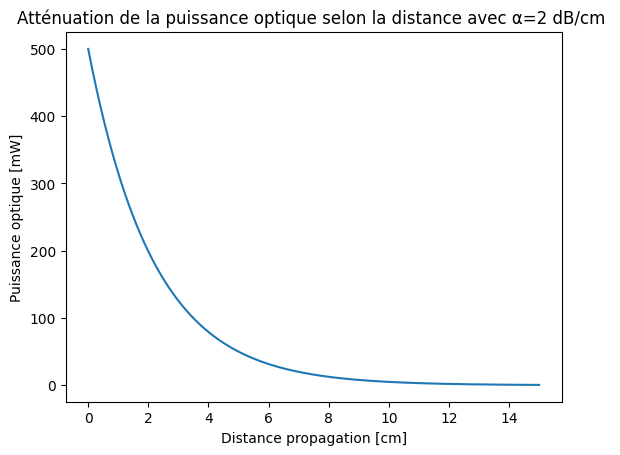

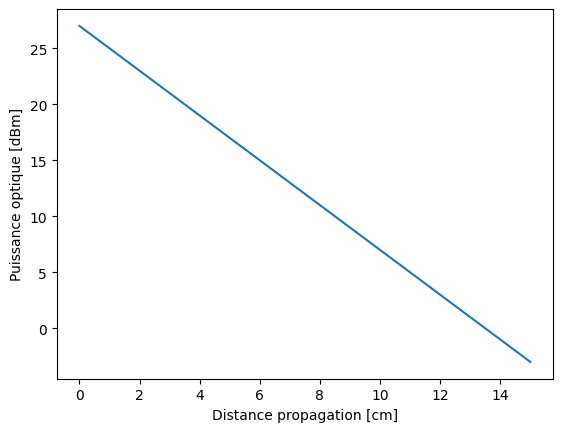

Puissance à 1cm = 24.98902429269998 [dBm]
Puissance à 1cm = 315.42958841672623 [mW]
Puissance à 1cm = 315.42958841672635 [mW]


In [71]:
λ = 600E-9 #[m]
n_phot_1s = 151E16
E_1phot = cte.h*cte.c/λ
P_0_W = n_phot_1s*E_1phot
α = 2 #[dB/cm]
D = 1 #[cm]

print("E_1phot =", E_1phot, "[J]")
print("Nombre de photons/s =", n_phot_1s)
print("P_0 =", P_0_W, "[J/s = W]")

D = np.linspace(0, 15, 1000)
P_0_dBm = mw_to_dbm(P_0_W*1000)
P_dBm = fonction_attenuation_dB(P_0_dBm, α, D)
P_mW = dBm_to_mW(P_dBm)

plt.plot(D, P_mW)
plt.title(f"Atténuation de la puissance optique selon la distance avec α={α} dB/cm ")
plt.ylabel("Puissance optique [mW]")
plt.xlabel("Distance propagation [cm]")
plt.show()

plt.plot(D, P_dBm)
plt.ylabel("Puissance optique [dBm]")
plt.xlabel("Distance propagation [cm]")
plt.show()

print("Puissance à 1cm =", fonction_attenuation_dB(P_0_dBm, α, 1), "[dBm]")
print("Puissance à 1cm =", dBm_to_mW(fonction_attenuation_dB(P_0_dBm, α, 1)), "[mW]")
print("Puissance à 1cm =", fonction_attenuation_mW(dBm_to_mW(P_0_dBm), α/fact_conv_att_dB_per_m_to_1_per_m, 1), "[mW]")


# Question 2 - Interface en diélectriques et condition modale (30%)

#### (A) (6 points) Une onde se propageant dans un milieu 1 arrive à incidence normale sur l’interface avec un milieu 2. Calculez la réflectivité et la transmittance et démontrez que la puissance est conservée si $\epsilon_1$  = 4.0 et $\epsilon_2$ = 1.0.

Pour une onde avec une certaine polarisation TE,$\perp$ ou TM,$\parallel$, les coefficients de réflexion et de transmission sont

$$
r_{TE} = \frac{E'_{10}}{E_{10}} = \frac{n_1 \cos \theta_1 - n_2 \cos \theta_2}{n_1 \cos \theta_1 + n_2 \cos \theta_2}\\
r_{TM} = \frac{E'_{10}}{E_{10}} = \frac{n_2 \cos \theta_1 - n_1 \cos \theta_2}{n_2 \cos \theta_1 + n_1 \cos \theta_2}
\\
t_{TE} = \frac{E_{20}}{E_{10}} = \frac{2 n_1 \cos \theta_1}{n_1 \cos \theta_1 + n_2 \cos \theta_2}\\
t_{TM} = \frac{E_{20}}{E_{10}} = \frac{2 n_1 \cos \theta_1}{n_2 \cos \theta_1 + n_1 \cos \theta_2}
$$


À incidence normale, le coefficient de réflexion se simplifie à
$$
r=\frac{n_1−n_2}{n_1+n_2}\\
t = \frac{2n_1}{n_1+n_2}
$$
Et pour passer de coefficient de réflexion à réflectivité :
$$
R = |r|^2\\
T = \frac{n_2}{n_1}|t|^2
$$

De plus, on peut trouver les indices de réfraction avec la permittivité électrique du milieu $ϵ_1 = 4$ et $ϵ_2 = 1$ sachant que
$$
v_p=\frac{1}{\sqrt{μ_0 μ_r ϵ_0 ϵ_r}}=\frac{ω}{k}=\frac{c}{n}\\
c=\frac{1}{\sqrt{μ_0 ϵ_0}}\\
n=\sqrt{μ_r ϵ_r} \approx \sqrt{ϵ_r}\\
⇓\\
n_1 = \sqrt{4} = 2 \quad\quad n_2 = \sqrt{1} = 1
$$

Ainsi, les coefficients de réflectivité et les coefficients de transmission sont
$$
r = \frac{2-1}{2+1} = \frac{1}{3}\\
R = \left|\frac{1}{3}\right|^2  = \frac{1}{9}
$$
Pour la réflectivité
$$
t = \frac{2⋅2}{2+1} = \frac{4}{3}\\
T = \frac{1}{2}\left|\frac{4}{3}\right|^2  = \frac{1}{2} \frac{16}{9} = \frac{8}{9}
$$
Ce qui respecte bien la loi de conservation de la puissance
$$ R + T = \frac{1}{9}+\frac{8}{9} =1$$

#### (B) (6 points) Une onde est incidente ($\theta_i$ = 25°) sur un empilement de 5 couches diélectriques dont les permittivités sont [1.5, 2.0, 3.0, 2.0, 1.5]. Quel sera l’angle à la sortie de l’empilement ?

Si l'onde revient dans le même milieu $n_6 =1$ que l'onde incidente dans $n_0 =1$, alors l'angle à la sortie sera le même.

Par contre, on peut vérifier l'onde n'aura pas de réflexion totale interne à l'une des interfaces.
$$
θ_C = \arcsin\left(\frac{n_i}{n_t}\right) \quad\quad n_i>n_t
$$

On rappelle la loi de Snell-Descartes:
$$
n_i\sin(θ_i) = n_t \sin(θ_t)
$$

In [72]:
from math import nan
def angle_snell(θ_i, n_i, n_t):
  """
  Angle input is in degree
  """
  θ_i_rad = np.deg2rad(θ_i)
  θ_t_rad = np.arcsin(n_i/n_t*np.sin(θ_i_rad))
  return float(np.rad2deg(θ_t_rad))

def angle_critique(n_i, n_t):
  """
  Return critic angle in degree
  """
  if n_i<n_t:
    # Comme l'indice transmis est plus grand que l'indice incident, il n'existe pas d'angle
    return np.inf
  θ_c_rad = np.arcsin(n_t/n_i)
  return np.rad2deg(θ_c_rad)


In [73]:
ϵ_r = [1, 1.5, 2.0, 3.0, 2.0, 1.5, 1]
n = np.sqrt(ϵ_r)

θ = [0,0,0,0,0,0,0] # Initialisation de l'angle dans chaque millieu
θ[0] = 20.0 # \degree l'angle d'incidence



# Calcul de l'angle dans chaque milieu
for i in range(len(θ)-1):
  θ[i+1] = angle_snell(θ[i],n[i],n[i+1])

print("θ° = ", θ)



# Calcul de l'angle critique de réflexion total interne à chaque interface
θ_c = np.zeros(len(θ)-1)
θ_c[0] = angle_critique(n[0], n[1])

for i in range(len(θ)-1):
  θ_c[i] = angle_critique(n[i],n[i+1])

print("θ_c°=", θ_c)



for i in range(len(θ_c)):
  # Itérer sur tous les angles et regarder si l'angle d'incidence est plus grand que l'angle
  # print(θ[i], " >?", θ_c[i])
  if θ[i] > θ_c[i]:
    print(f"L'angle dans le milieu {i} est de {θ[i]}° et est plus grand que {θ_c[i]}° ce qui résulte en une réflexion totale interne.")

θ° =  [20.0, 16.215941397841586, 13.995445358891416, 11.388782791007355, 13.995445358891418, 16.215941397841586, 20.000000000000004]
θ_c°= [        inf         inf         inf 54.73561032 60.         54.73561032]


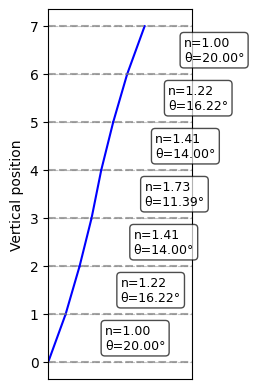

In [74]:
# @title

# Plot the light ray path
fig, ax = plt.subplots()

# Starting point
x = 0
y = 0

# Draw interfaces
# Removed the code that draws vertical lines
# for i in range(1, len(n)):
#     ax.axvline(x=x, color='grey', linestyle='--')
#     x += 1  # Arbitrary spacing for visualization

x = 0
# Draw ray path
for i in range(len(θ)):
    # Length of segment, adjusted for visualization
    length = 1 / np.cos(np.deg2rad(θ[i]))
    x_end = x + length * np.sin(np.deg2rad(θ[i])) # Use sin for horizontal movement
    y_end = y + length * np.cos(np.deg2rad(θ[i])) # Use cos for vertical movement

    ax.plot([x, x_end], [y, y_end], 'b-')

    # Add text annotations for refractive index and angle
    mid_x = x + (x_end - x) / 2
    mid_y = y + (y_end - y) / 2
    # Adjust text position to the right of the midpoint
    text_x = mid_x + 1 # Offset to the right
    text_y = mid_y
    ax.text(text_x, text_y, f'n={n[i]:.2f}\nθ={θ[i]:.2f}°', fontsize=9, ha='left', va='center', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))


    x = x_end
    y = y_end

# Add horizontal grid lines at refractive index change points
y_interfaces = [0]
current_y = 0
for i in range(len(θ)):
    length = 1 / np.cos(np.deg2rad(θ[i]))
    y_change = length * np.cos(np.deg2rad(θ[i])) # Vertical movement in each layer
    current_y += y_change
    y_interfaces.append(current_y)

for y_pos in y_interfaces:
    ax.axhline(y=y_pos, color='grey', linestyle='--', alpha=0.7)


#ax.set_xlabel("Distance (arbitrary units)")
ax.set_ylabel("Vertical position")
ax.set_aspect('equal') # Keep the aspect ratio equal
ax.set_xticks([]) # Remove x-axis ticks and labels
ax.set_xlim([0, 3]) # Limit x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7) # Keep only horizontal grid
plt.show()

#### (C) (6 points) Pour une onde incidente d’un milieu 1 sur un milieu 2 avec n1 = 3.481, n2 = 1.484 et $\theta_i$ = 80°, trouvez la profondeur à laquelle l’amplitude du champ électrique du mode TE atteint sa valeur 1/e si $\lambda_0$ = 1550 nm.

Ici, il s'agit d'un problème d'onde évanescente.

Comme $n_1>n_2$, calculons l'angle critique
$$
θ_c = \arcsin\left(\frac{n_2}{n_1}\right) = \arcsin\left(\frac{1.484}{3.481}\right) = 25.23°
$$
Ce qui confirme qu'il y aurait bien une réflexion totale interne.

Selon la formule dans les notes de cours, le vecteur d'onde transmis dans la direction perpendiculaire à la surface sera :
$$
k_{tx} =iα_{tx} = i\sqrt{k_1^2\sin^2(θ_i)-k_2^2}
$$
Pour que le champ électrique transmis soit :
$$
\vec{E}_t(\vec{r}) = \vec{E}_t e^{ik_{tx}\vec{r}} =\vec{E}_t e^{-α_{tx}\vec{r}}
$$
Ainsi, la norme du champ électrique est proportionnelle à une exponentielle décroissante avec un facteur
$$
α_{tx} = \sqrt{k_1^2\sin^2(θ_i)-k_2^2}
$$
où
$$
k_1 = \frac{n_1 2π}{λ_0} = \frac{2π⋅3.481}{1550×10^{-9}} = 1.4111 \times 10^7\ [1/m] \\
k_2 = \frac{n_2 2π}{λ_0} =\frac{2π⋅1.484}{1550×10^{-9}} = 6.0156 \times 10^6\ [1/m] \\
$$

Ce qui donne
$$
α_{tx} = \sqrt{(1.4111 × 10^7)^2\sin^2(80°) - (6.0156 × 10^6)^2} = 1.2527 \times 10^7 \ [1/m]
$$

La distance à laquelle l'amplitude $|E|$ devient $\frac{1}{e^1}E_0 = 0.3678E_0$ est alors.

$$
\frac{1}{e^1}E_0 = E_0e^{-α_{tx} x}\\
-1 = -α_{tx}x\\
x = 1/α_{tx} = 7.9828 \times 10^{-8} \ [m] = 79.84 \ [nm]
$$



In [75]:
n_1 = 3.481
n_2 = 1.484
θ_i = 80
λ_0 = 1550E-9 #m

θ_c  = angle_critique(n_1, n_2)
print("θ_c° =", θ_c)

θ_c° = 25.233881285450078


*Un polariseur permet de séparer la polarisation-s ($\perp$) et la polarisation-p ($//$) d'un faisceau incident. À l'angle de Brewster, la réflectivité de la polarisation-p est nulle et seule la polarisation-s est réfléchie.*
![Brewster polarizer](https://upload.wikimedia.org/wikipedia/commons/b/b8/Brewster-polarizer.svg)

*On vous demande de concevoir un polariseur basé sur le concept d'angle de Brewster. Pour ce faire, vous disposez d'un nombre illimité de lames de silice (SiO $_2$ ). Considérez que $n_{SiO_2}=1.44$ et que la lumière incidente se propage dans l'air $n_{air}=1.0$.  Assumez que la propagation de la lumière dans la silice n'induit pas de pertes optiques.*

#### (D) (6 points) À quel angle ( $\theta_B$ ) la lumière doit-elle être incidente sur votre polariseur?

On calcule l'angle de Brewster avec la formule suivante.
$$
θ_B = \arctan\left(\frac{n_2}{n_1}\right) = \arctan\left(\frac{1.44}{1}\right) = 55.22°
$$

In [76]:
θ_B = np.rad2deg(np.arctan(1.44/1))
print("θ_B° = ", θ_B)

θ_B° =  55.22216863363612


#### (E) (6 points) Tracez la réflectance (R) pour la polarisation-s ($\perp$, TE) en fonction du nombre de lames utilisées.
*Suggestion: écrivez d'abord une fonction qui calcule la transmission à travers une lame en Pol-S*

Nous avons deux différents changements d'interface entre l'air $n_1=1$ et la silice $n_2=1.44$.

Nous assumons que l'angle d'incidence sera choisi comme étant l'angle de Brewster
$$θ_i = θ_B = 55.22°$$
Cela résulte à un angle dans le verre de
$$
n_i\sin(θ_i) = n_t\sin(θ_t)\\
θ_t=\arcsin\left(\frac{n_i}{n_t}\sin(θ_i)\right)\\
θ_t=\arcsin\left(\frac{1}{1.44}\sin(55.22)\right) = 34.78°\\
$$
La formule de la réflectance à une interface est
$$
R_\perp = |r_\perp|^2 = \left|\frac{n_i\cos(θ_i) - n_t \cos(θ_t)}{n_i\cos(θ_i) + n_t \cos(θ_t)}\right|^2
$$


$$
R_{\perp,1\rightarrow2} = \left|\frac{1\cos(55.22°) - 1.44 \cos(34.78°)}{1\cos(55.22°) + 1.44 \cos(34.78°)}\right|^2 =0.1220
$$
Il y aura aussi une partie réfléchie à l'interface $2\rightarrow 1$
$$
R_{\perp,2\rightarrow1} = \left|\frac{1.44\cos(34.78°) - 1\cos(55.22°)}{1.44\cos(34.78°) + 1 \cos(55.22°)}\right|^2 = 0.1220
$$
On pourrait considérer une infinité de réflexions à l'intérieur, mais allons approximer qu'il y a seulement une réflexion à l'intérieur de la lame de verre (comme sur le schéma plus haut).

Ainsi, la partie de puissance qui est réfléchie et transmise après une lame est de

$$
R_{1\ lame} = R_{\perp, 1→2} + R_{\perp, 2→1} = 0.1220 + 0.1220 = 0.2440\\
T_{1\ lame} = 1 - R_{1\ lame} = 0.756
$$

On peut ainsi tracer la puissance optique transmise et réfléchie en fonction du nombre de lames.
$$
T_{n\ lame} = T_{1\ lame}^n\\
R_{n\ lame} = 1-T_{n\ lame} = 1 - (1-R_{1\ lame})^n
$$


Text(0, 0.5, 'Reflectance R')

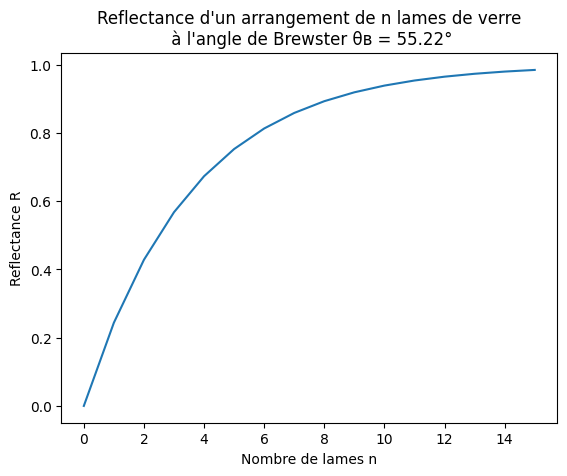

In [77]:
R_1_lame = 0.2440

nombre_lame = 15
R_n_lame = []
for i in range(nombre_lame+1):
  R_n_lame.insert(i,1-(1-R_1_lame)**i)


plt.plot(range(nombre_lame+1), R_n_lame)
plt.title(f"Reflectance d'un arrangement de n lames de verre\n à l'angle de Brewster θʙ = {θ_B:.2f}°")
plt.xlabel("Nombre de lames n")
plt.ylabel("Reflectance R")


# Question 3 - Dispersion et propagation d'une impulsion optique (15%)

#### (A) (5 points) Démontrez que le temps de propagation  (e.g. le délai de groupe $T_g$) d'une impulsion optique dans un milieu homogène de longueur L est donné par: $$ T_g = L \left( \frac{n}{c}+\frac{\omega}{c}\frac{dn}{d\omega}  \right) = L \left( \frac{n}{c}-\frac{\lambda}{c}\frac{dn}{d\lambda}  \right) $$

La dispersion chromatique est induite par la variation de l'indice de réfraction pour chaque longueur d'onde que compose une impulsion de lumière. Théoriquement, si un pulse était monochromatique, il se propagerait avec la même vitesse de phase $v$ ainsi le temps de propagation d'une onde monochromatique serait.
$$
T = \frac{L}{v_g} \ \left[\frac{m}{m/s} = s\right]
$$

Rappelons la définition de la vitesse de groupe qui est la dérivée du nombre d'onde $k = \frac{n(ω)ω}{c}$ par rapport à la fréquence angulaire $ω$.

$$
v_g = \frac{∂ω}{∂k} = \left[\frac{∂k}{∂ω}\right]^{-1}\\
\frac{1}{v_g}= \frac{∂}{∂ω}\left(\frac{n(ω)ω}{c}\right) = \frac{1}{c}\left(n(ω) + ω\frac{dn}{dω} \right)
$$
On peut ensuite changer toutes les fréquences angulaires $ω$ en longueur d'onde avec $ω = \frac{2πc}{λ}$ ainsi que la règle des dérivées en chaine.
$$
\frac{dλ}{dω} = -\frac{λ}{ω}\\
⇓\\
\frac{dn}{dω} = \frac{dn}{dλ}\frac{dλ}{dω} = \frac{dn}{dλ}⋅\frac{-λ}{ω}
$$
Ce qui donne

$$
\frac{1}{v_g} = \frac{1}{c}\left(n + \frac{2πc}{λ}\frac{dn}{dλ}⋅\frac{-λ}{ω} \right)\\
\frac{1}{v_g} = \frac{n(λ)}{c} - \frac{1}{c}\frac{2πc}{ω}\frac{dn}{dλ}\\
$$
avec $ω = \frac{2πc}{λ} → \frac{2πc}{ω} = λ$
$$
\frac{1}{v_g} = \frac{n(λ)}{c} - \frac{λ}{c}\frac{dn}{dλ}\\
$$

Pour finalement nous donner le temps de groupe
$$
T_g = \frac{L}{v_g} = L\left(\frac{n(λ)}{c} - \frac{λ}{c}\frac{dn}{dλ}\right)
$$

Considérez la propagation d'une impulsion optique dans un guide d'onde de lithium niobate sur une distance de 100 cm. L'indice de réfraction est donné par la formule de dispersion suivante:
$$ n^2-1=\frac{2.6734λ^2}{λ^2-0.01764}+\frac{1.2290λ^2}{λ^2-0.05914}+\frac{12.614λ^2}{λ^2-474.60}. $$

#### (B) (2.5 points) Tracez la vitesse de groupe en fonction de la longueur d'onde.

Nous avons l'équation de Sellmeier
$$ n=\sqrt{\frac{B_1λ^2}{λ^2-C_1}+\frac{B_2λ^2}{λ^2-C_2}+\frac{B_3λ^2}{λ^2-C_3}+1}$$
avec les constantes pour le LiNbO₃ à 25°C selon [reférence](https://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o).
$$
B_1 = 2.6734\\
B_2 = 1.2290\\
B_3 = 12.614\\
C_1 = 0.01764 [μm^2]\\
C_2 = 0.05914 [μm^2]\\
C_3 = 474.60\ [μm^2]\\
$$

In [78]:
def calculate_n_LiNbO3_function_λ(λ, B_1 = 2.6734, B_2 = 1.2290, B_3 = 12.614, C_1 = 0.01764, C_2 = 0.05914,C_3 = 474.60):
  """
  Wavlenght input is in [m]
  """
  λ = λ*1E6 #but Sellmeir take in μm
  n = np.sqrt((B_1*λ**2/(λ**2 - C_1)) + (B_2*λ**2/(λ**2 - C_2)) +(B_3*λ**2/(λ**2 - C_3)) + 1)
  return n

Pour vérifier que la fonction est bien écrite, une comparaison avec la [référence suivante](https://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o) est faite. Le site web nous dit qu'à $n(λ=1550nm) = 2.2111$, ce qui est bien le cas.

Indice n(λ=1550 nm) =  2.2111110086535737


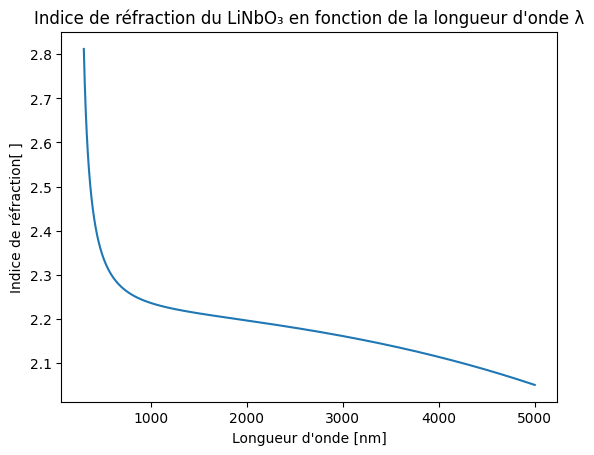

In [79]:
print("Indice n(λ=1550 nm) = ", calculate_n_LiNbO3_function_λ(1550E-9))

λ = np.linspace(300E-9, 5000E-9, 1000000)
n_LiNbO3 = calculate_n_LiNbO3_function_λ(λ)


plt.plot(λ*1E9, n_LiNbO3)
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Indice de réfraction[ ]")
plt.title("Indice de réfraction du LiNbO₃ en fonction de la longueur d'onde λ")
plt.show()


Ensuite on trouve la vitesse de groupe avec la formule
$$
v_g = \frac{c}{n_g} = \left[\frac{n(λ)}{c} - \frac{λ}{c}\frac{dn}{dλ}\right]^{-1} = \frac{c}{n(λ) - λ\frac{d\ n(λ)}{dλ}}\\
$$

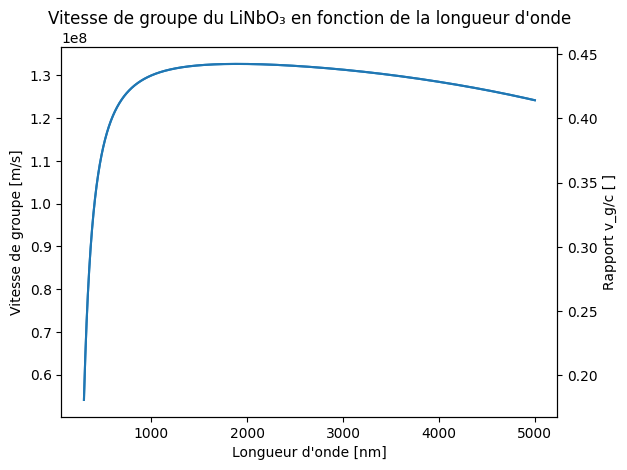

In [80]:
dnノdλ= np.gradient(n_LiNbO3, λ)

v_g = cte.c/(n_LiNbO3 - λ*dnノdλ)

fig, ax1 = plt.subplots()

ax1.plot(λ*1E9, v_g)
ax1.set_xlabel("Longueur d'onde [nm]")
ax1.set_ylabel("Vitesse de groupe [m/s]")
ax1.set_title("Vitesse de groupe du LiNbO₃ en fonction de la longueur d'onde")


ax2 = ax1.twinx()
ax2.plot(λ*1E9, v_g/cte.c)
ax2.set_ylabel("Rapport v_g/c [ ]", color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.show()


#### (C) (2.5 points) Tracez la dispersion de la vitesse de groupe (GVD) en fonction de la longueur d'onde. unités en fs $^2$ m $^{-1}$ .

La Group Velocity Dispersion (GVD) est la variation de la vitesse de groupe inverse par rapport à la fréquence angulaire $ω$. Cela revient à dériver deux fois le vecteur d'onde.
$$
GVD = \frac{∂^2k}{∂ω^2} = \frac{∂}{∂ω}\frac{∂k}{∂ω} = \frac{∂}{∂ω}v_g^{-1} = \frac{∂}{∂ω}\left(\frac{n(λ)}{c} - \frac{λ}{c}\frac{dn(λ)}{dλ}\right)
$$
On change encore ici la dérivée par rapport à $ω$ avec $\frac{dλ}{dω} = -\frac{λ}{ω}$
$$
GVD = \frac{1}{c}\left(\frac{∂}{∂ω}n(λ) - \frac{∂}{∂ω}λ\frac{dn(λ)}{dλ}\right)\\
GVD = \frac{1}{c}\left(\frac{∂λ}{∂ω}\frac{dn(λ)}{dλ} - \frac{∂λ}{∂ω}\frac{d}{dλ}\left(λ\frac{dn(λ)}{dλ}\right)\right)
\\
$$
Avec la dérivée de produit $(uv)' = u'v + uv'$
$$
GVD = \frac{1}{c}\left(-\frac{λ}{ω}⋅\frac{dn(λ)}{dλ} +\frac{λ}{ω}⋅\left(\frac{dλ}{dλ}\frac{dn(λ)}{dλ} + λ\frac{d^2n(λ)}{dλ^2}\right)\right)
\\
GVD = \frac{1}{c}\left(-\frac{λ}{ω}⋅\frac{dn(λ)}{dλ} +\frac{λ}{ω}\frac{dn(λ)}{dλ} + \frac{λ^2}{ω}\frac{d^2n(λ)}{dλ^2}\right)
\\
GVD = \frac{1}{c}\left(\frac{λ^2}{ω}\frac{d^2n(λ)}{dλ^2}\right)
\\
$$
et finalement avec $ω = \frac{2πc}{λ}$
$$
GVD = \frac{λ^3}{2πc^2}\frac{d^2n(λ)}{dλ^2} \quad \quad \frac{[m]^3}{[m/s]^2}\frac{[\ ]^2}{[m]^2} = \left[\frac{s^2}{m}\right]
\\
$$
Pour avoir les unités en $\left[\frac{fs^2}{m}\right]$ on multiplie par $(1\times10^{15})^2 = 1\times10^{30}$
$$
GVD = \frac{λ^3}{2πc^2}\frac{d^2n(λ)}{dλ^2}×10^{30} \quad \left[\frac{fs^2}{m}\right]
$$

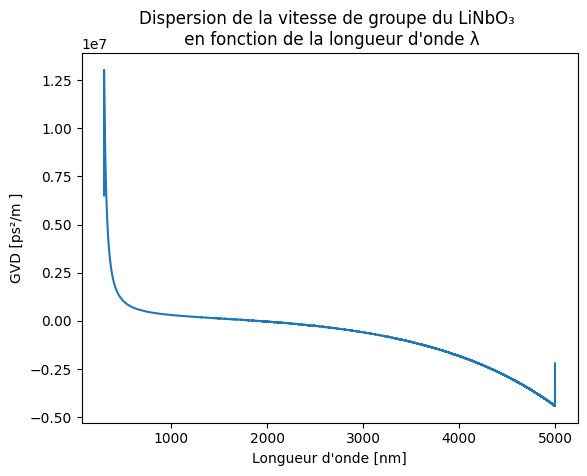

In [81]:
d2nノdλ2 = np.gradient(dnノdλ, λ)

GVD = (λ**3*d2nノdλ2*1E30)/(2*np.pi*cte.c**2)

plt.plot(λ*1E9, GVD)
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("GVD [ps²/m ]")
plt.title("Dispersion de la vitesse de groupe du LiNbO₃ \n en fonction de la longueur d'onde λ")
plt.show()


#### (D) (5 points) Vous faites propager deux impulsions, la première à une longueur d'onde de 800 nm et la seconde à 1550 nm. Quel sera le délai entre ces deux impulsions après 100 cm.

$$
T_g = \frac{L}{v_g} = L\left(\frac{n(λ)}{c} - \frac{λ}{c}\frac{dn}{dλ}\right)
$$


In [82]:
def calculate_T_g(L, v_g):
  """
  L is in meters
  v_g are in m/s
  """
  return L/v_g

# On trouve la v_g à 800nm et 1550nm avec la fonction interpolate de numpy
def interpolate_λ(target_lambda, λ_array, v_g_array):
  return(np.interp(target_lambda, λ_array, v_g_array))

v_g_800nm =interpolate_λ(800E-9, λ, v_g)
v_g_1550nm =interpolate_λ(1550E-9, λ, v_g)

print(f"v_g_800nm = {v_g_800nm:.0f} m/s")
print(f"v_g_1550nm ={v_g_1550nm:.0f} m/s\n")

# T = L/v [m/(m/s) = s]
T_g_800nm = 1/v_g_800nm
T_g_1550nm = 1/v_g_1550nm
ΔT_g = T_g_800nm - T_g_1550nm

print(f"T_g_800nm = {T_g_800nm} s")
print(f"T_g_1550nm = {T_g_1550nm} s")
print(f"Δ_g {ΔT_g}s = {ΔT_g*1E12:.2f} ps")

v_g_800nm = 127110299 m/s
v_g_1550nm =132436161 m/s

T_g_800nm = 7.8671831604824e-09 s
T_g_1550nm = 7.550807826865992e-09 s
Δ_g 3.163753336164082e-10s = 316.38 ps


# Question 4 - Méthode de l'indice effectif (20%)
Pour répondre aux questions suivantes, utilisez les bases de données:

https://refractiveindex.info/?shelf=main&book=Si3N4&page=Luke

https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson

Considérez la géométrie suivante:

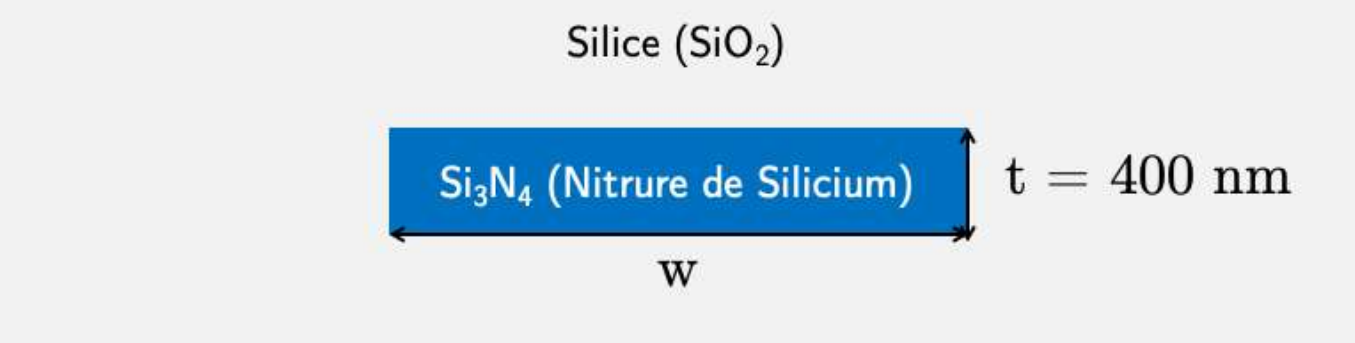

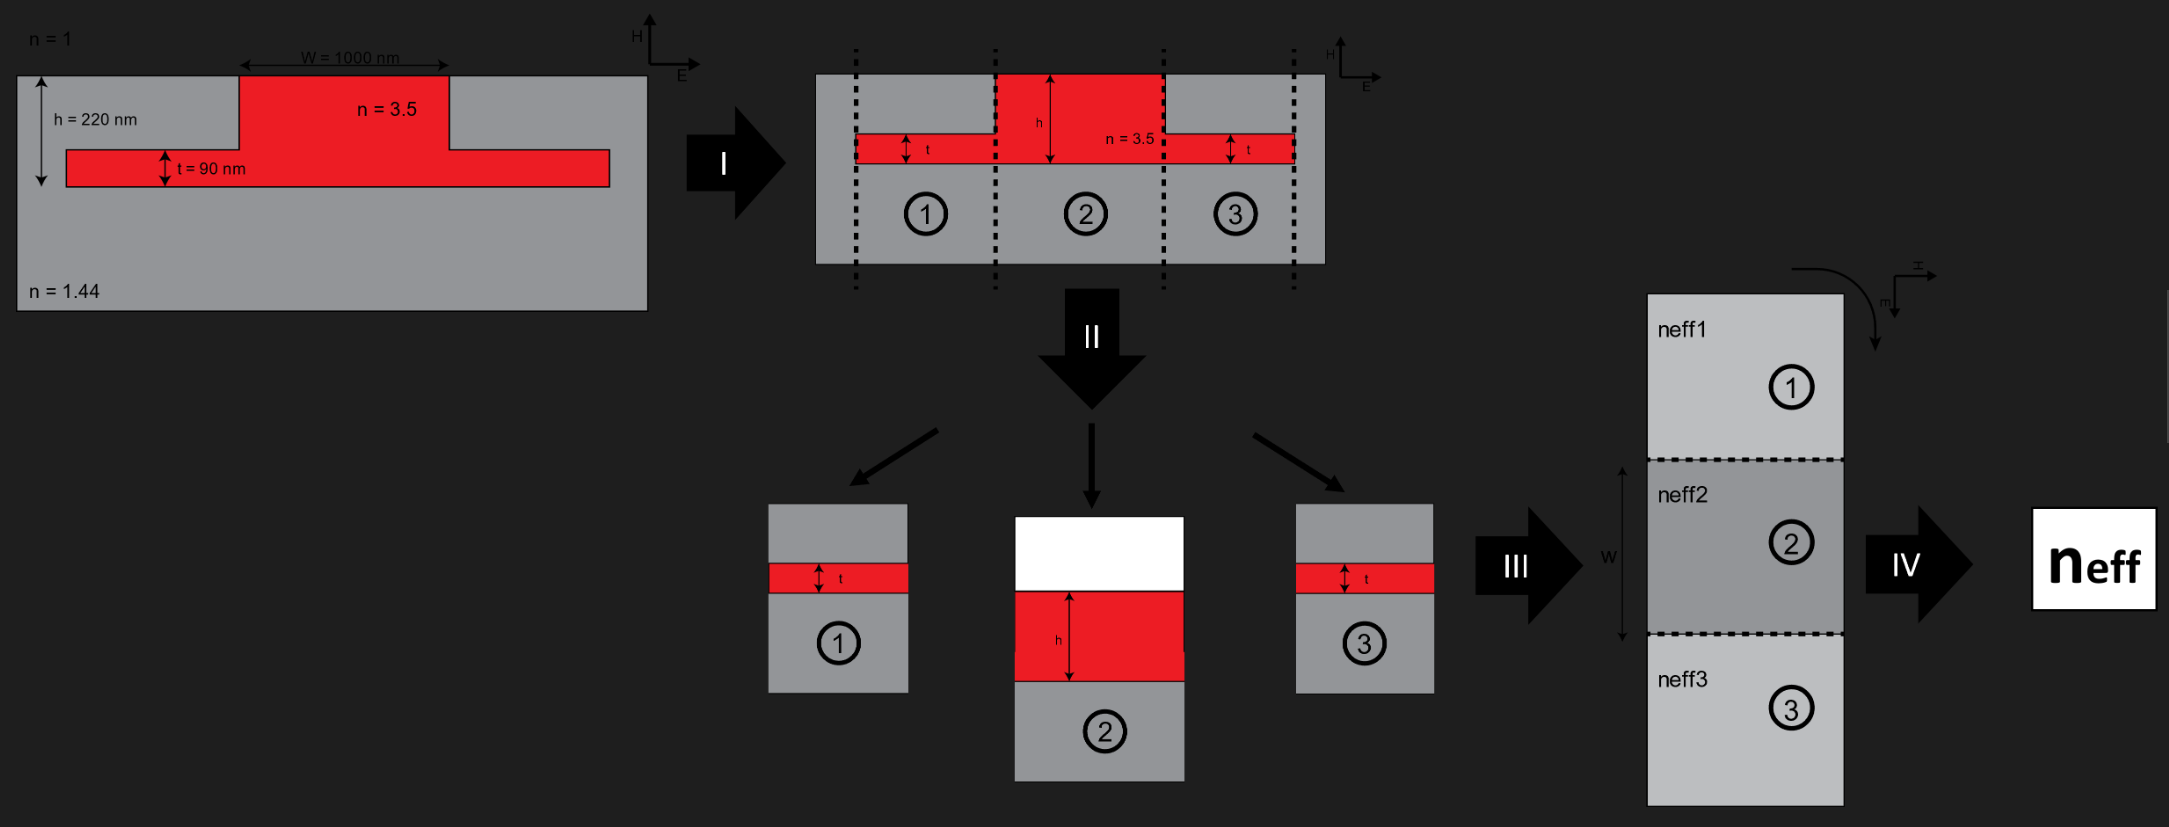

#### (A) (5 points) Écrire une fonction qui implémente la méthode de l'indice effectif. Cette fonction doit accepter les arguments suivants: un vecteur longueur d'onde, un scalaire largeur $w$ et un scalaire épaisseur $t$. Votre fonction doit retourner le mode fondamental TE.

In [83]:
def calculate_n_SiO2_function_λ(λ, B_1 = 0.6961663, B_2 = 0.4079426, B_3 = 0.8974794, C_1 = 0.0684043, C_2 = 0.1162414,C_3 = 9.896161):
  """
  Wavlenght input is in [m]
  """
  λ = λ*1E6 #but Sellmeir take in μm
  n = np.sqrt((B_1*λ**2/(λ**2 - C_1**2)) + (B_2*λ**2/(λ**2 - C_2**2)) +(B_3*λ**2/(λ**2 - C_3**2)) + 1)
  return n


def calculate_n_Si3N4_function_λ(λ, B_1 = 3.0249, B_2 = 40314, B_3 = 0, C_1 = 0.1353406, C_2 = 1239.842,C_3 = 0):
  """
  Wavlenght input is in [m]
  """
  λ = λ*1E6 #but Sellmeir take in μm
  n = np.sqrt((B_1*λ**2/(λ**2 - C_1**2)) + (B_2*λ**2/(λ**2 - C_2**2)) +(B_3*λ**2/(λ**2 - C_3**2)) + 1)
  return n

On doit séparer la géométrie en 3 sections.

Dans notre cas, la section ① et ③ sera seulement du SiO₂ avec l'indice effectif qui est directement l'indice du matériau.

Pour le milieu ②, on calcule l'indice effectif du sandwich d'une épaisseur $4$.
Finalement, on calcule l'indice effectif du sandwich ① ② ③, avec les indices effectifs de chaque section. Il est à faire attention que le sandwich horizontal est tourné de $90°$, ainsi le mode calculé TM sera dans le référentiel original, le mode TE.

n_eff_test_float = [1.742022211061525]
n_eff_test_vector = [1.811310191276235, 1.8095648281648515, 1.8078259957777398, 1.8060936604597206, 1.8043677897492256, 1.8026483523016243, 1.8009353178308154, 1.7992286570161486, 1.7975283414629695, 1.7958343436337054, 1.7941466367897538, 1.792465194940578, 1.7907899927913136, 1.789121005701488, 1.787458209627407, 1.7858015810924406, 1.7841510971388699, 1.7825067353002688, 1.7808684735481706, 1.7792362902759862, 1.777610164258662, 1.7759900746244104, 1.7743760008246179, 1.772767922616749, 1.7711658200208282, 1.7695696733135207, 1.7679794629955414, 1.7663951697836462, 1.7648167745675438, 1.7632442584149712, 1.761677602542541, 1.7601167883016724, 1.7585617971634155, 1.7570126107036221, 1.7554692105904677, 1.7539315785700997, 1.7523996964546404, 1.7508735461188216, 1.7493531094730872, 1.7478383684700318, 1.746329305087774, 1.7448259013228056, 1.743328139182213, 1.7418360006763638, 1.7403494677979727, 1.7388685225867213, 1.7373931469807988, 1.7359233

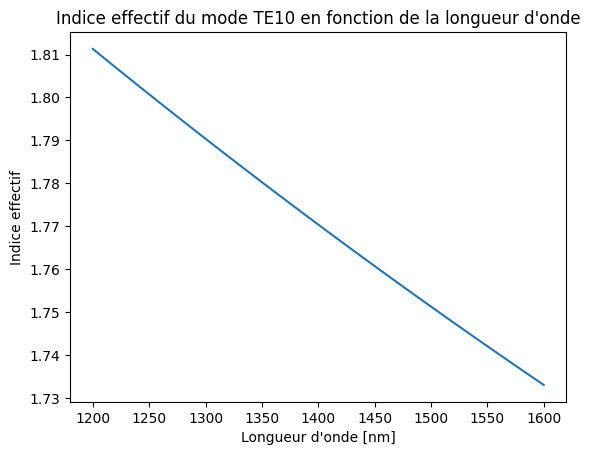

In [84]:
def n_eff_TE_10(λ_vector, w, t):
  """
  Input:
    λ in [m]
    w the width dimension of the waveguide in [m]
    t the tallness dimension of the waveguide in [m]

    The refractive index of the SiO₂ and Si₃N₄ are calculated in function of the wavelength with Sellmeir formula
  """
  n_eff = []
  if isinstance(λ_vector, (float, int)):
    λ_vector = [λ_vector]

  for λ in λ_vector:
    n_SiO2 = calculate_n_SiO2_function_λ(λ)
    n_Si3N4 = calculate_n_Si3N4_function_λ(λ)

    n_2_eff = guide_1d_analytique(λ, t, n_SiO2, n_Si3N4, n_SiO2)[0][0][0]
    # We take the TE mode so [0] and we take the fondamental mode so [0][0]

    # We calculate the n_eff of total waveguide
    n_eff.append(guide_1d_analytique(λ, w, n_SiO2, n_2_eff, n_SiO2)[1][0][0])
    # Due to the calculation after the rotation of 90° we need to take the TE mode [1]
    # We take the fundamental, so [0]

  return n_eff

λ = 1550E-9
n_eff_test_float = n_eff_TE_10(λ, 10E-6, t=400E-9)
print(f"n_eff_test_float = {n_eff_test_float}")


λ = np.linspace(1200E-9, 1600E-9, 50)
n_eff_test_vector = n_eff_TE_10(λ, 10E-6, t=400E-9)
print("n_eff_test_vector =", n_eff_test_vector)

plt.plot(λ*1E9, n_eff_test_vector)
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Indice effectif")
plt.title("Indice effectif du mode TE10 en fonction de la longueur d'onde")
plt.show()


#### (B) (2.5 points) Pour quelle largeur $w$ le guide d'onde sera-t-il monomode à 1550 nm? Quel sera l'indice effectif? Considérez la polarisation TE et que les autres paramètres restent constants. Donnez votre réponse au nanomètre près. Utilisez cette valeur pour les questions suivantes.

La dernière fonction créée était spécifiquement faite pour calculer le mode fondamental. Je vais en créer une nouvelle plus générale qui calcule tous les modes TE pour une certaine longueur d'onde.

In [85]:
def n_eff_TE(λ_vector, w, t=400E-9):
  """
  Input:
    λ in [m]
    w the width dimension of the waveguide in [m]
    t the tallness dimension of the waveguide in [m]

    The refractive index of the SiO₂ and Si₃N₄ are calculated in function of the wavelength with Sellmeir formula
  """
  n_eff_all_modes = []
  if isinstance(λ_vector, (float, int)):
    λ_vector = [λ_vector]

  for λ in λ_vector:
    n_SiO2 = calculate_n_SiO2_function_λ(λ)
    n_Si3N4 = calculate_n_Si3N4_function_λ(λ)

    n_2_eff_modes = guide_1d_analytique(λ, t, n_SiO2, n_Si3N4, n_SiO2)[0]
    # We take the TE mode so [0]

    # We calculate the n_eff of total waveguide for each mode in n_2_eff_modes
    n_eff_modes_at_lambda = []
    # Iterate through the modes for this wavelength
    for n_2_eff in n_2_eff_modes[0]:
      n_eff_modes_at_lambda.append(guide_1d_analytique(λ, w, n_SiO2, n_2_eff, n_SiO2)[1][0])
      # Take all TM modes (which are TE for the rotated waveguide)
    n_eff_all_modes.append(n_eff_modes_at_lambda)

  return n_eff_all_modes

λ = np.linspace(1200E-9, 1600E-9, 50)
n_eff_monomode = n_eff_TE(λ, 10E-6, t=400E-9)
#print("n_eff_test_vector =", n_eff_monomode)


# check if there is more than one mode at that wavelength
for i in range(len(λ)):
  #print("i=",i, "λ=", λ[i], "len mode =", len(n_eff_monomode[i][0]), " n_eff =", n_eff_monomode[i]) #Debug print
  pass

In [86]:
width = np.linspace(1000E-9, 500E-9, 100)

width_that_are_monomode = []
for i in width:
  #print("Width=", i)
  n_eff_at_width = n_eff_TE(1550E-9, i, t=400E-9)
  #print(n_eff_at_width)
  #print("len", len(n_eff_at_width[0][0]))
  if len(n_eff_at_width[0][0]) == 1:
    width_that_are_monomode.append(float(i))


biggest_width_monomode = width_that_are_monomode[0]
print(f"L'indice effectif pour une largeur de {biggest_width_monomode} [m] est de {n_eff_TE(1550E-9,biggest_width_monomode, t=400E-9)[0][0][0]:.4f} ")
biggest_width_monomode = 793E-9

L'indice effectif pour une largeur de 7.929292929292929e-07 [m] est de 1.6211 


#### (C) (2.5 points) Vérifiez votre fonction en traçant l'indice effectif et l'indice de groupe en fonction de la longueur d'onde sur la plage [1550 nm, 1600 nm].

À partir de l'indice effectif du mode à différentes longueurs d'onde, il est possible de calculer l'indice de groupe avec
$$
n_g = n_{eff} - λ \frac{dn_{eff}}{dλ}
$$

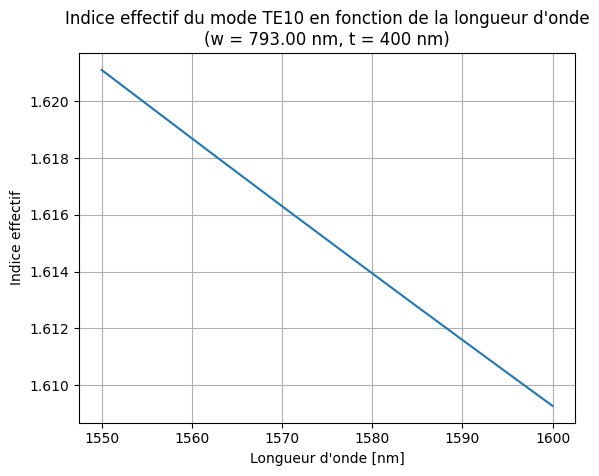

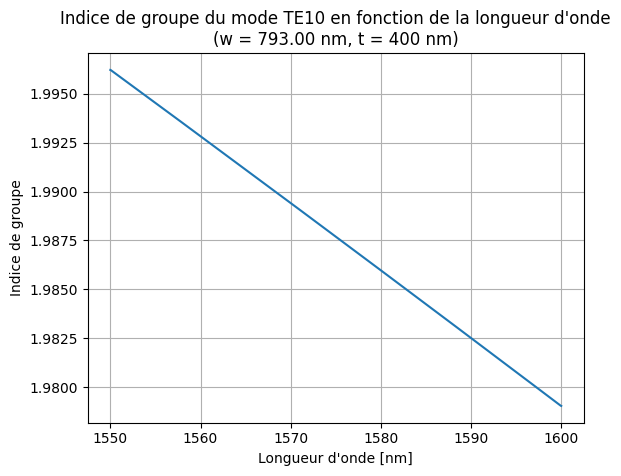

In [87]:
λ = np.linspace(1550E-9, 1600E-9, 1000)
n_eff = n_eff_TE_10(λ, w=biggest_width_monomode, t=400E-9)

n_g = n_eff - λ*np.gradient(n_eff, λ)

plt.plot(λ*1E9, n_eff)
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Indice effectif")
plt.title(f"Indice effectif du mode TE10 en fonction de la longueur d'onde\n(w = {biggest_width_monomode*1e9:.2f} nm, t = {400e-9*1e9:.0f} nm)")
plt.grid(True)
plt.show()


plt.plot(λ*1E9, n_g)
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Indice de groupe")
plt.title(f"Indice de groupe du mode TE10 en fonction de la longueur d'onde\n(w = {biggest_width_monomode*1e9:.2f} nm, t = {400e-9*1e9:.0f} nm)")
plt.grid(True)
plt.show()

#### (D) (5 points) Calculez le délai de groupe entre un signal à 1540 nm et un signal à 1560 nm. Considérez une propagation sur 10 cm.

Le délais de groupe se calcul comme la différence de temps de parcours entre une propagation sur un certaine distance connaissant la vitesse de groupe à chaque longueur d'onde.
$$
T = L/v_g = \frac{L n_g}{c}\\
ΔT = T_2 - T_1
$$

In [88]:
# Recreate a new n_eff array bettween 1520 and 1580
λ = np.linspace(1520E-9, 1580E-9, 1000)
n_eff = n_eff_TE_10(λ, w=biggest_width_monomode, t=400E-9)
n_g = n_eff - λ*np.gradient(n_eff, λ)

In [89]:
n_g_1540 = interpolate_λ(1540E-9, λ, n_g)
n_g_1560 = interpolate_λ(1560E-9, λ, n_g)

n_eff_1540 = interpolate_λ(1540E-9, λ, n_eff)
n_eff_1560 = interpolate_λ(1560E-9, λ, n_eff)

#print(f"n_g_1540 {n_g_1540}")
#print(f"n_g_1560 {n_g_1560}")

T_λ_1540 = 0.1*n_g_1540/cte.c
T_λ_1560 = 0.1*n_g_1560/cte.c

ΔT = T_λ_1540 - T_λ_1560
print(f"ΔT  = {ΔT*1E12:.3f} [ps]")

ΔT  = 2.255 [ps]


In [90]:
def calculate_delta_T(λ1, λ2, w,L=0.1, t=400E-9):
  """
  inputs:
    λ1 [m]
    λ2 [m]
    L [m]
    w [m]
    t [m]
  Returns:
    ΔT of the group delay in secs
  """
  λ_range = np.linspace(min(λ1, λ2) - 20E-9, max(λ1, λ2) + 20E-9, 1000)

  # Calculate n_eff
  n_eff_range = n_eff_TE_10(λ_range, w=w, t=t)
  n_g_range = n_eff_range - λ_range * np.gradient(n_eff_range, λ_range)

  # find the n_g at λ1 and λ2
  n_g_λ1 = interpolate_λ(λ1, λ_range, n_g_range)
  n_g_λ2 = interpolate_λ(λ2, λ_range, n_g_range)

  # find ΔT
  T_λ1 = L*n_g_λ1/cte.c
  T_λ2 = L*n_g_λ2/cte.c
  ΔT = T_λ1 - T_λ2

  return ΔT


# Verify it's good
ΔT_test = calculate_delta_T(1540E-9, 1560E-9, biggest_width_monomode, 0.1, 400E-9)
print(f"ΔT  = {ΔT_test*1E12:.4f} [ps]")

ΔT  = 2.2552 [ps]


#### (E) (5 points) Quelle est la tolérance sur la largeur $w$ afin que le
délai de groupe reste dans un plage $\pm 5\%$ de la valeur calculez en (D)?

Créons un code qui sweep la largeur $w$, pour chaque largeur.

Calcule l'indice effectif entre 1620 et 1680 nm. Calculer l'indice de groupe avec la dérivée de l'indice effectif.

Calcule le temps de propagation de chacune des ondes sur 10cm.

Calcule la différence de temps entre les deux longueurs d'onde.

Comparer à partir de quelles valeurs de $w$ que le $ΔT>2.255 ± 5\% \ [ps]$.


In [92]:
#WARNING: not optimize code, take approximately 3 minutes to calculate#
deviation_pourcentage_of_w = 0.10
number_of_w = 100
w = np.linspace((1-deviation_pourcentage_of_w)*biggest_width_monomode, (1+deviation_pourcentage_of_w)*biggest_width_monomode, number_of_w)

pourcentage_criteria = 0.05
low_limit_ΔT = ΔT_test*(1-pourcentage_criteria)
high_limit_ΔT = ΔT_test*(1+pourcentage_criteria)
print(f"Les valeurs limites sont entre {low_limit_ΔT*1E12:.4f} et {high_limit_ΔT*1E12:.4f} [ps]")

ΔT_at_w = []
widths_inside_limit = []

for current_w in w:
  current_ΔT = calculate_delta_T(1540E-9, 1560E-9, current_w, 0.1, 400E-9) # Fixed parameters order
  ΔT_at_w.append(float(current_ΔT))
  if current_ΔT >= low_limit_ΔT and current_ΔT <= high_limit_ΔT:
    widths_inside_limit.append(current_w)

print("\nValeurs de ΔT calculées pour chaque largeur :", [Δt*1e12 for Δt in ΔT_at_w]) # Print ΔT values in ps

if widths_inside_limit:
  min_width = min(widths_inside_limit)
  max_width = max(widths_inside_limit)
  print(f"\nLa plus petite largeur dans la tolérance : {min_width*1e9:.2f} [nm]")
  print(f"La plus grande largeur dans la tolérance : {max_width*1e9:.2f} [nm]")
else:
  print("\nAucune largeur trouvée dans la tolérance spécifiée.")

Les valeurs limites sont entre 2.1424 et 2.3679 [ps]

Valeurs de ΔT calculées pour chaque largeur : [2.5398415930551312, 2.536911475944427, 2.5339816242796003, 2.5310520922792383, 2.528123233462757, 2.525194126299566, 2.522265903503705, 2.5193379133730716, 2.5164105684582045, 2.5134837798861995, 2.5105575910523985, 2.507632041434927, 2.504707167472125, 2.501783703107805, 2.498859613298058, 2.4959382629623312, 2.4930152302687274, 2.490102862322738, 2.4871743270828723, 2.4842552697001787, 2.481337193717134, 2.478420137583885, 2.4755043452920353, 2.4725892131312603, 2.4696771951100702, 2.466762784311277, 2.4638423161952097, 2.4609411311896086, 2.4580395642724437, 2.4551245309400027, 2.4522182088213347, 2.4493132497725494, 2.4464096882918343, 2.443507570863948, 2.4406068892973214, 2.4377085882993192, 2.4348100652151095, 2.4319172266518305, 2.4290194744707936, 2.426117808105736, 2.423235364607995, 2.42034023116156, 2.4174579811534613, 2.414581009581617, 2.4116875687473067, 2.408805050645835